# Monte Carlo Simulation

**1. Simulering av pasientstrøm og belegg (Monte Carlo simulering)**<br>
<br>
**Formål**: Simulere variasjonen i antall pasienter og belegg på avdelingen.<br>
**Hvordan**: Du kan bruke Monte Carlo-simulering for å modellere usikkerhet i pasientankomster og oppholdstid. Dette innebærer å generere et stort antall scenarier basert på historisk data, og beregne sannsynligheten for at avdelingen blir full eller overfylt.<br>
**Resultat**: Estimere risikoen for overbelastning og evaluere hvor ofte det kan oppstå situasjoner med kapasitetsmangel.<br>

## Import necessary libraries

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

## Input data

In [86]:
def datalast_behandling(path: str) -> pd.DataFrame:
    fin_hf_med = pd.read_excel(path, sheet_name = "medisinsk hammerfest")
    fin_hf_kir_ort = pd.read_excel(path, sheet_name = "kirurgisk hammerfest")

    # post kolonne
    fin_hf_med["post"] = "medisinsk"
    fin_hf_kir_ort["post"] = "kirurgisk"

    # merge and order datasets
    fin_data = pd.concat([fin_hf_med, fin_hf_kir_ort], axis=0).sort_values("Dato").reset_index()
    fin_data.drop(["index"], axis=1, inplace=True)
    fin_data['helg'] = fin_data['Dato'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
    return fin_data

In [87]:
path = "./data/fin_hf_datagrunnlag.xlsx"
fin_data = datalast_behandling(path)

,År,Måned,Dato,Antall inn på post,Antall pasienter ut av Post,Belegg pr. dag,Antall liggedogn,Senger normert,Beleggsprosent,Gjennomsnitts belegg,Antall senger i bruk,post,helg
0,2022,januar,2022-01-01,3,3,22.291667,22,33,0.675505,22.291667,33,medisinsk,1
1,2022,januar,2022-01-01,2,0,12.625000,12,22,0.742647,12.625000,17,kirurgisk,1
2,2022,januar,2022-01-02,10,6,25.416667,23,33,0.770202,25.416667,33,medisinsk,1
3,2022,januar,2022-01-02,5,3,14.625000,13,22,0.860294,14.625000,17,kirurgisk,1
4,2022,januar,2022-01-03,5,3,27.916667,27,33,0.845960,27.916667,33,medisinsk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029,2024,oktober,2024-10-11,14,12,20.458333,20,30,0.786859,20.458333,26,medisinsk,0
2030,2024,oktober,2024-10-12,4,4,11.000000,12,22,0.647059,11.000000,17,kirurgisk,1
2031,2024,oktober,2024-10-12,7,6,21.916667,23,30,0.842949,21.916667,26,medisinsk,1
2032,2024,oktober,2024-10-13,3,9,22.208333,23,30,0.854167,22.208333,26,medisinsk,1


In [89]:
data = fin_data 
post = "medisinsk"
weekend = False
predictions = "False"
year = 2023
total_beds = 26  
average_stay = 3 # Normal
num_simulations = 1000

## Monte Carlo 

**Formål**: Simulere hvordan variasjon i antall pasientankomster og gjennomsnittlig liggetid påvirker sannsynligheten for overbelastning.<br>
<br>
**Nødvendig data**:<br>
<br>
1. Antall pasientankomster per dag (gjennomsnittlig eller historisk fordeling).<br>
2. Gjennomsnittlig liggetid per pasient.<br>
3. Totalt antall senger på avdelingen.<br>

In [104]:
def monte_carlo_simulation(data: pd.DataFrame, total_beds: int, average_stay: int, num_simulations: int, post: str, weekend: bool = False, predictions: bool = False, year: int = 2024):
    if post == "medisinsk":
        df_fin = data[data["post"] == "medisinsk"]
    elif post == "kirurgisk":
        df_fin = data[data["post"] == "kirurgisk"]
    
    if weekend == True:
        df_fin = df_fin[df_fin["helg"] == 1]
    # else:
    #     df_fin = df_fin[df_fin["helg"] == 0]

    if predictions == True:
        df_fin = df_fin[df_fin["År"] == 2025]
    else:
        df_fin = df_fin[df_fin["År"] == year]
    
    df_fin = df_fin.reset_index()
    df_index = df_fin.index.values
    df_index = [x +1 for x in df_index]
    df_fin["day of year"] = df_index
    
    

    total_bed_occupancy_overall = 0
    total_overloaded_days = 0
    total_patients_waiting = 0
    total_patients_admitted = 0
    
    # For visualiseringen
    all_overload_days = [] 
    all_occupancy_percents = []
    
    for sim in range(num_simulations):
        beds_occupied = []
        daily_overload = 0  # dager med overbelastning
        bed_occupancy = 0   # belegget
        
        # For visualiseringer
        if sim == 0:  
            daily_occupancy_record = []  
        
        for index, row in df_fin.iterrows(): 
            beds_occupied = [stay for stay in beds_occupied if stay > row["day of year"]] # Oppdater senger
            new_patients = row["Antall inn på post"]
            total_patients_admitted += new_patients


            overload_today = False

            # Sjekk om det er en ledig seng
            for _ in range(new_patients):
                if len(beds_occupied) < total_beds:

                    # Tildel en seng og definer hvor lenge de vil ligge inne
                    stay_duration = max(1, int(np.random.normal(average_stay, 2)))  # Normalfordeling
                    beds_occupied.append(row["day of year"] + stay_duration)
                else:
                    # Overbelastning, pasient må vente
                    overload_today = True
                    total_patients_waiting += 1
            if overload_today:
                daily_overload += 1
            
            bed_occupancy += len(beds_occupied) / total_beds

            if sim == 0:
                daily_occupancy_record.append(len(beds_occupied) / total_beds)

        total_overloaded_days += daily_overload
        total_bed_occupancy_overall += bed_occupancy / df_fin["day of year"].max()
        all_overload_days.append(daily_overload)
        
        if sim == 0:
            all_occupancy_percents = daily_occupancy_record

    # Beregn gjennomsnittlig overbelastning, beleggsprosent og sannsynlighet
    avg_overload_days = total_overloaded_days / num_simulations
    avg_occupancy_percentage = (total_bed_occupancy_overall / num_simulations) * 100
    waiting_probability = total_patients_waiting / total_patients_admitted
    
    return df_fin, avg_overload_days, avg_occupancy_percentage, waiting_probability, all_overload_days, all_occupancy_percents

# Kjør Monte Carlo-simuleringen
data, avg_overload_days, avg_occupancy_percentage, waiting_probability, all_overload_days, all_occupancy_percents = monte_carlo_simulation(fin_data, total_beds, average_stay, num_simulations, "medisinsk", year = 2023)

# Print resultater
print(f"Gjennomsnittlig antall dager med overbelastning per år: {avg_overload_days:.2f} dager")
print(f"Gjennomsnittlig beleggsprosent over året: {avg_occupancy_percentage:.2f}%")
print(f"Sannsynligheten for at pasienter må vente på en seng: {waiting_probability:.2%}")


Gjennomsnittlig antall dager med overbelastning per år: 56.04 dager
Gjennomsnittlig beleggsprosent over året: 79.90%
Sannsynligheten for at pasienter må vente på en seng: 5.69%


## Resultat

In [114]:
def monte_carlo_dager_overbelastning(all_overload_days: list):
    # 1. antall dager med overbelastning
    plt.figure(figsize=(10, 6))
    plt.hist(all_overload_days, bins=20, color='skyblue', edgecolor='black')
    plt.title('Antall dager med overbelastning i 1000 simuleringer')
    plt.xlabel('Antall dager med overbelastning')
    plt.ylabel('Antall simuleringer')
    plt.grid(True)
    plt.show()

def monte_carlo_beleggsprosent(data: pd.DataFrame, all_occupancy_percents: list):
    # 2. daglig beleggsprosent for én simulering (visualisere årets belastning)
    plt.figure(figsize=(10, 6))
    days_in_plot = range(data["day of year"].min(), data["day of year"].max()+1)
    plt.plot(days_in_plot, np.array(all_occupancy_percents) * 100, color='blue')
    plt.title('Daglig beleggsprosent for ett år (én simulering)')
    plt.xlabel('Dag')
    plt.ylabel('Beleggsprosent (%)')
    plt.grid(True)
    plt.show()

def monte_carlo_waiting_probability(waiting_probability: float):
    # 3. sannsynlighet for at pasienter må vente på seng
    plt.figure(figsize=(6, 6))
    labels = ['Fikk seng umiddelbart', 'Måtte vente på seng']
    sizes = [1 - waiting_probability, waiting_probability]
    colors = ['lightgreen', 'salmon']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Sannsynlighet for at pasienter må vente på seng')
    plt.axis('equal')
    plt.show()

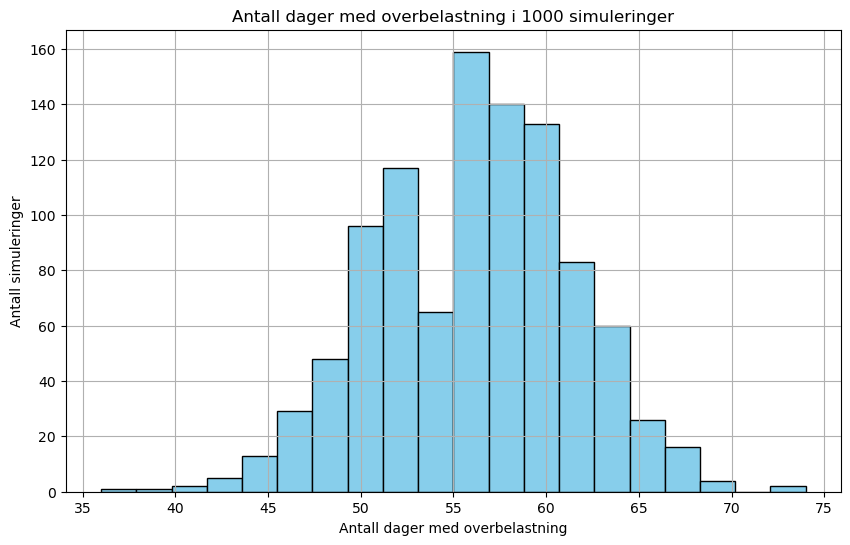

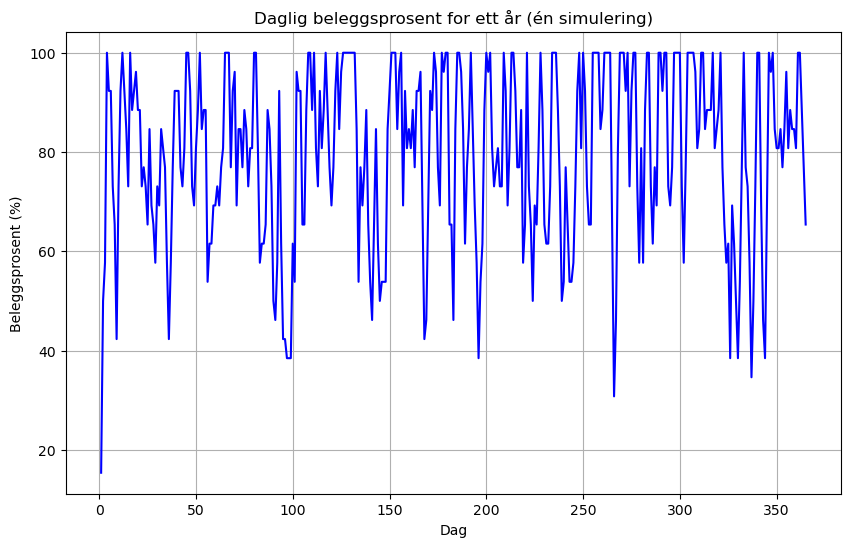

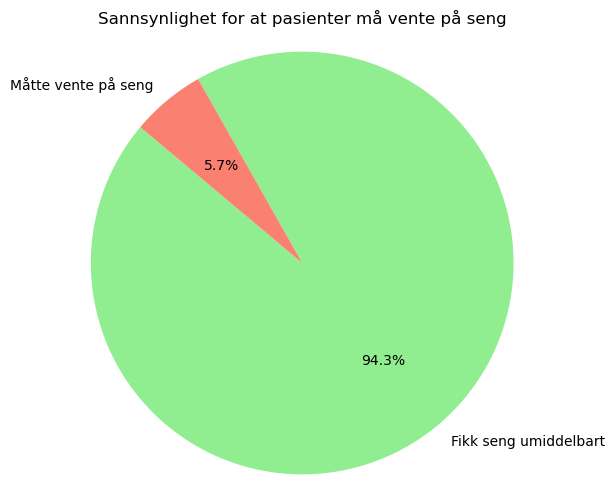

In [115]:
monte_carlo_dager_overbelastning(all_overload_days)
monte_carlo_beleggsprosent(data, all_occupancy_percents)
monte_carlo_waiting_probability(waiting_probability)

**Verdi for sykehuset**:<br>
<br>
1. Identifisere risiko for overbelastning.<br>
2. Finne sannsynligheten for at kapasiteten blir overskredet, slik at bemanningsplaner eller kapasiteten kan justeres.<br>